### SYS5110 Simulation Project ###

v2

Scenario 3: Hire one more employee


In [14]:
# Basic Parameters
num_queues = 1    # single queue. UNUSED
num_calls = 1000  # Number of calls to simulate
num_servers = 11  # Number of agents (servers) answering calls

In [15]:
# Generate inter-arrival times for all 1000 calls fitted on distribution
import numpy as np
from scipy.stats import expon

# generate hourly call distribution (with low-volume and peak times)
def generate_interarrival_times(hourly_calls, minutes_per_hour=60):
    """
    Generate inter-arrival times for a given hourly call volume distribution.

    Parameters:
        hourly_calls: List[int] - Number of calls per hour (6 AM to 10 PM).
        seconds_per_hour: int - Number of seconds in an hour (default: 3600).

    Returns:
        List[float] - Inter-arrival times in seconds for all calls.
    """
    inter_arrival_times = []
    for calls in hourly_calls:
        rate = calls / minutes_per_hour if calls > 0 else 0
        if rate > 0:
            # Generate inter-arrival times for the number of calls in each hour
            times = expon(scale=1 / rate).rvs(size=calls)
            inter_arrival_times.extend(times)
    return inter_arrival_times

# Hourly call preset discrete distribution of 1000 calls over 16 hours of working time
hourly_calls = [50, 50, 50, 50, 50, 50, 87, 87, 88, 88, 100, 100, 50, 50, 25, 25]
data_inter_arrival_times = generate_interarrival_times(hourly_calls)

# Print a few sample inter-arrival times
print("Sample Inter-Arrival Times:", data_inter_arrival_times[:10])
print("Total Number of Inter-Arrival Times Generated:", len(data_inter_arrival_times))


Sample Inter-Arrival Times: [1.0231099635998775, 0.8414975570722121, 2.4189750912741226, 1.1181373481702936, 0.270472908440617, 0.4227939371413666, 3.7775704953020752, 0.48477979519563474, 0.21604514416722764, 0.8364362168204421]
Total Number of Inter-Arrival Times Generated: 1000


In [16]:
from scipy.stats import gamma

def generate_waiting_times(num_samples, alpha=1.99, beta=2.79):
    """
    Generate a list of random waiting times based on a gamma distribution.

    Parameters:
    - num_samples (int): Number of waiting times to generate.
    - alpha (float): Shape parameter of the gamma distribution (default is 1.99).
    - beta (float): Scale parameter of the gamma distribution (default is 2.79).

    Returns:
    - list: Randomly generated waiting times.
    """
    return gamma.rvs(a=alpha, scale=beta, size=num_samples).tolist()

# Generate array of waiting times for 1000 calls in the day
data_max_waiting_times = generate_waiting_times(num_calls)
#print(waiting_times)

# Print a few sample max waiting times
print("Sample Max. Waiting Times (in minutes):", data_max_waiting_times[:10])
print("Total Number of Max. Waiting Times Generated:", len(data_max_waiting_times))

Sample Max. Waiting Times (in minutes): [0.9474122180909348, 11.975962528343638, 14.38841331440531, 4.764745108984641, 13.470018793609038, 11.384202899881695, 1.7612103523104259, 5.874555930136457, 4.287600808059636, 8.86078225376227]
Total Number of Max. Waiting Times Generated: 1000


In [17]:
# Custom functions for generating service time for one call
def generate_service_time():
    return np.random.exponential(1 / 5) * 50  # Service time ~ Exponential(5)

In [18]:
# Main program
import numpy as np
import pandas as pd
from scipy.stats import expon


# Initialize variables with pre-existing data:
arrival_times = []  # List to store arrival times
service_times = []  # List to store service times
max_call_waiting_times = []   # List to store max waiting times before abandonning calls

# Initialize variables with values calculated from simulation
waiting_times = []  # List to store waiting times
waiting_times_with_abandon = []   # List to store waiting times including those who abandonned
waiting_times_abandon_only = []   # List to store waiting times of abandonned calls
departure_times = []  # List to store departure times
answered_call_count = 0 # Number of calls successfully picked up and answered
abandon_call_count = 0  # Number of calls abandoned due to exceeding max. waiting time

# output model measurement (sensitivity analysis) metrics:
server_utilization = [0] * num_servers  # Track total service time handled by each server

server_end_times = [0] * num_servers  # Track when each server will be free

# set interarrival times of 1000 calls from preset data
#interarrival_times = []
#interarrival_times = generate_interarrival_times(hourly_calls, seconds_per_hour=3600, samples_per_hour=100)
interarrival_times = data_inter_arrival_times

# set max. waiting times of 1000 calls from preset data
max_waiting_times = data_max_waiting_times

# Simulate calls
for i in range(num_calls):
    # Generate arrival time; first arrival time set to 0
    if i == 0:
        arrival_time = 0
    else:
        interarrival_time = interarrival_times[i]
        arrival_time = arrival_times[-1] + interarrival_time
    #arrival_times.append(arrival_time)

    # Generate service time (call duration)
    service_time = generate_service_time()
    #service_times.append(service_time)

    # Set max. waiting time
    max_waiting_time = max_waiting_times[i]

    # Assign the earliest available server
    next_available_time = min(server_end_times)
    server_index = server_end_times.index(next_available_time)
    if arrival_time >= next_available_time:
        # No waiting, server is free
        waiting_time = 0
        start_service_time = arrival_time
    else:
        # Waiting required
        waiting_time = next_available_time - arrival_time
        ### Abandon call if waiting time exceeds maximum waiting time; continue for loop
        if waiting_time > max_waiting_time:
          waiting_times_with_abandon.append(waiting_time)
          abandon_call_count+=1
          continue

        start_service_time = next_available_time

    # append to lists if call not abandoned
    arrival_times.append(arrival_time)
    service_times.append(service_time)

    waiting_times.append(waiting_time)
    waiting_times_with_abandon.append(waiting_time)


    # Calculate departure time
    departure_time = start_service_time + service_time
    departure_times.append(departure_time)

    # Update server end time and utilization
    server_end_times[server_index] = departure_time
    server_utilization[server_index] += service_time

# Calculate total number of calls answered
answered_call_count = num_calls - abandon_call_count

# Calculate total simulation time
total_simulation_time = max(departure_times)

# Calculate utilization rates for each server
server_utilization_rates = [
    (util / total_simulation_time) * 100 for util in server_utilization
]


Output section

Average waiting time (including abandoned calls)

Average waiting time (excluding abandoned calls)

Average server utilization

Abandoned calls

Abandoned calls rate

Graph distribution for abandoned calls throughout the day(?)




In [19]:

# Create a DataFrame to display results
df = pd.DataFrame({
    #"Call": range(1, num_calls + 1),
    "Call": range(1, answered_call_count + 1),
    "Arrival Time (min)": arrival_times,
    "Waiting Time (min)": waiting_times,
    "Service Time (min)": service_times,
    "Departure Time (min)": departure_times,
})

# Display the results
print("Call Data:")
print(df)

# Display server utilization rates
print("\nServer Utilization Rates:")
for i, rate in enumerate(server_utilization_rates):
    print(f"Server {i + 1}: {rate:.2f}%")




Call Data:
     Call  Arrival Time (min)  Waiting Time (min)  Service Time (min)  \
0       1            0.000000            0.000000            7.784902   
1       2            0.841498            0.000000           35.137561   
2       3            3.260473            0.000000           30.304367   
3       4            4.378610            0.000000            4.531406   
4       5            4.649083            0.000000           10.834314   
..    ...                 ...                 ...                 ...   
504   505          551.790327            7.741918            6.589366   
505   506          554.928018            5.885415            2.301141   
506   507          555.514092            6.831707            0.181058   
507   508          558.405393            4.121464           11.045710   
508   509          559.236379            3.878196            2.701794   

     Departure Time (min)  
0                7.784902  
1               35.979058  
2               33.564839  


In [20]:
# Metrics Calculation

# Average waiting time (including abandoned calls)
average_waiting_time_including_abandon = (
    sum(waiting_times_with_abandon) / len(waiting_times_with_abandon)
    if waiting_times_with_abandon else 0
)

# Average waiting time (excluding abandoned calls)
average_waiting_time_excluding_abandon = (
    sum(waiting_times) / len(waiting_times) if waiting_times else 0
)

# Average server utilization
average_server_utilization = sum(server_utilization_rates) / num_servers

# Abandoned calls
abandoned_calls = abandon_call_count

# Abandoned calls rate
abandoned_calls_rate = (abandon_call_count / num_calls) * 100

# Display Metrics
print("Simulation Metrics:")
print(f"1. Average Waiting Time (Including Abandoned Calls): {average_waiting_time_including_abandon:.2f} minutes")
print(f"2. Average Waiting Time (Excluding Abandoned Calls): {average_waiting_time_excluding_abandon:.2f} minutes")
print(f"3. Average Server Utilization: {average_server_utilization:.2f}%")
print(f"4. Number of Abandoned Calls: {abandoned_calls}")
print(f"5. Abandoned Calls Rate: {abandoned_calls_rate:.2f}%")


Simulation Metrics:
1. Average Waiting Time (Including Abandoned Calls): 6.22 minutes
2. Average Waiting Time (Excluding Abandoned Calls): 1.96 minutes
3. Average Server Utilization: 72.17%
4. Number of Abandoned Calls: 491
5. Abandoned Calls Rate: 49.10%


In [21]:
######

### Usage ###

You can change the 10* coefficient in the generate_service_time() function to scale the service time length distribution. (e.g. multiply by 10 to increase the average service time length by 10 times)

If num_calls is changed (from default 1000),


### Scenarios TODO: ###

1. Additional agent(s)/server for entire duration
2. Improved agency working efficiency, i.e. lower service time
3. Efficient resource allocation, i.e.

### Output TODO: ###

Graphs requested:
  Interarrival time distribution graph (Gamma CDF)
  Service time distribution graph

  Waiting time scatterplot for all callers




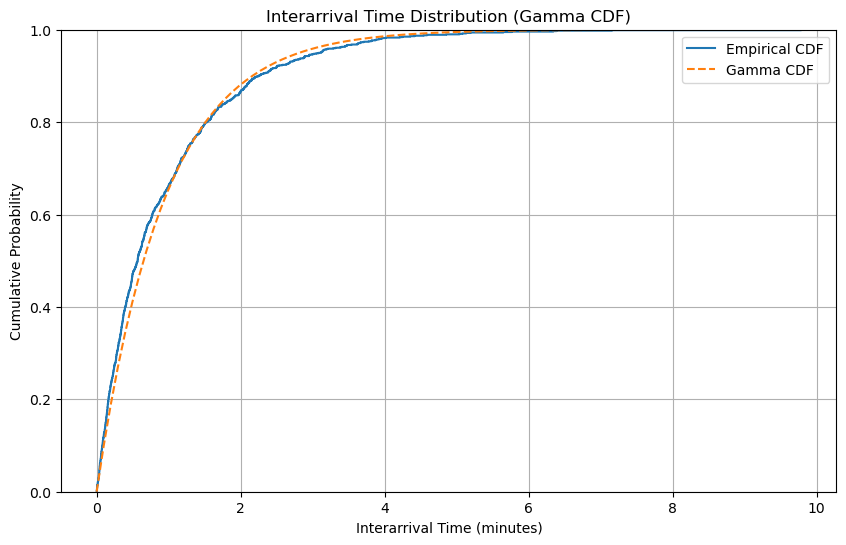

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Interarrival Time Distribution Graph (Gamma CDF)
plt.figure(figsize=(10, 6))
sns.ecdfplot(data_inter_arrival_times, stat='proportion', label='Empirical CDF')
x = np.linspace(0, np.max(data_inter_arrival_times), 100)
plt.plot(x, gamma.cdf(x, a=1, scale=np.mean(data_inter_arrival_times)), label='Gamma CDF', linestyle='--')
plt.title('Interarrival Time Distribution (Gamma CDF)')
plt.xlabel('Interarrival Time (minutes)')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)
plt.show()

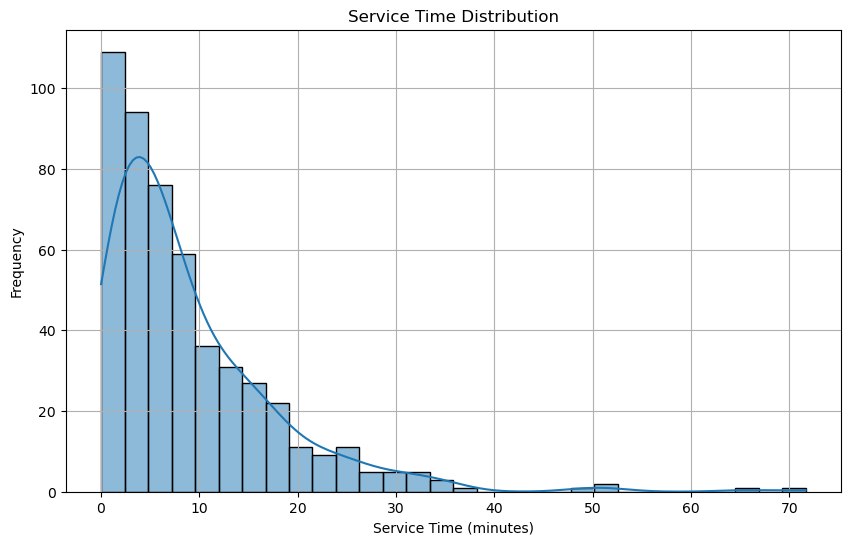

In [23]:
# 2. Service Time Distribution Graph
plt.figure(figsize=(10, 6))
sns.histplot(service_times, kde=True, bins=30)
plt.title('Service Time Distribution')
plt.xlabel('Service Time (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

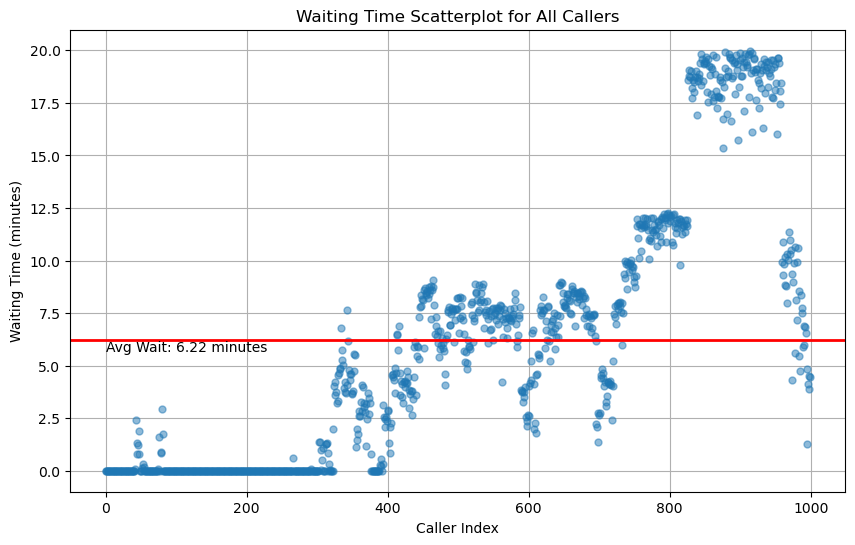

In [25]:
# 3. Waiting Time Scatterplot for All Callers
plt.figure(figsize=(10, 6))
plt.plot(range(num_calls), waiting_times_with_abandon, 'o', markersize=5, alpha=0.5)
plt.axhline(y=average_waiting_time_including_abandon, color='red', linewidth=2)  # Reference line at 12.13 minutes as the average of waiting times (including abandoned calls)
plt.text(0, average_waiting_time_including_abandon, f"Avg Wait: {round(average_waiting_time_including_abandon, 2)} minutes",
         verticalalignment='top', fontsize=10)
plt.title('Waiting Time Scatterplot for All Callers')
plt.xlabel('Caller Index')
plt.ylabel('Waiting Time (minutes)')
plt.grid(True)
plt.show()